In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import cv
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Read the data

In [2]:
train_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv")

## Data Overview

In [3]:
print ("Train shape" + str(train_data.shape))
print ('Test shape' +  str(test_data.shape))

Train shape(1460, 81)
Test shape(1459, 80)


In [4]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
# 各rowに含まれるNaNの数
train_data.isnull().sum(axis=1).head(15)

0     5
1     4
2     4
3     4
4     4
5     3
6     4
7     4
8     4
9     4
10    5
11    4
12    6
13    4
14    4
dtype: int64

In [7]:
# 各カラムに含まれるNaNの数
train_data.isnull().sum(axis=0).head(15)

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
Alley           1369
LotShape           0
LandContour        0
Utilities          0
LotConfig          0
LandSlope          0
Neighborhood       0
Condition1         0
Condition2         0
dtype: int64

## Dataset Cleaning

In [8]:
# まずはデータをくっつける
traintest = pd.concat([train_data, test_data], axis = 0, ignore_index=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [9]:
#  NaNも値だとみなした上で各カラムのユニークな値を数える
feats_counts = traintest.nunique(dropna = False)

In [10]:
feats_counts.sort_values()[:15]

CentralAir      2
Street          2
Utilities       3
Alley           3
HalfBath        3
LandSlope       3
PavedDrive      3
KitchenAbvGr    4
LandContour     4
ExterQual       4
LotShape        4
BsmtHalfBath    4
GarageFinish    4
PoolQC          4
MiscFeature     5
dtype: int64

In [11]:
# ラベルエンコーディング
traintest_enc =  pd.DataFrame(index = traintest.index)

for col in tqdm_notebook(traintest.columns):
    traintest_enc[col] = traintest[col].factorize()[0]

In [12]:
# ラベル張り替えたら全く同一になるカラムがあるかどうか
dup_cols = {}

for i, c1 in enumerate(tqdm_notebook(traintest_enc.columns)):
    for c2 in traintest_enc.columns[i + 1:]:
        if c2 not in dup_cols and np.all(traintest_enc[c1] == traintest_enc[c2]):
            dup_cols[c2] = c1

In [13]:
dup_cols # なかった

{}

## Data type

In [14]:
nunique = traintest.nunique(dropna=False)

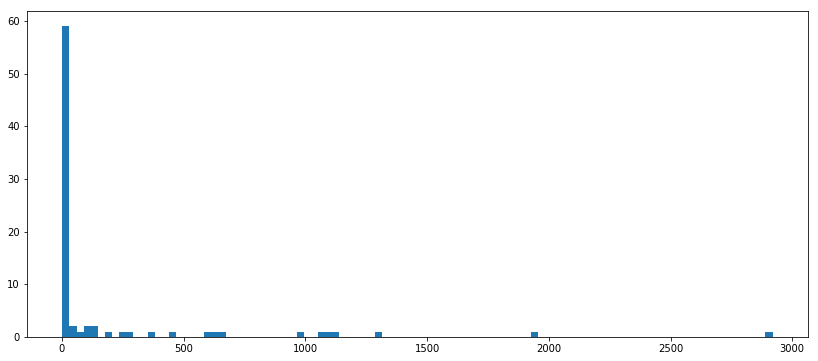

In [15]:
plt.figure(figsize=(14,6))
_ = plt.hist(nunique.astype(float), bins=100)

たくさんの種類の値をとるカラムは限られている。大半はカテゴリカル素性か？

In [16]:
# 1500種類以上の値をとるカラムは何？
mask = (nunique.astype(float) > 1500)
traintest.loc[:, mask]

,Id,LotArea
0,1,8450
1,2,9600
2,3,11250
3,4,9550
4,5,14260
5,6,14115
6,7,10084
7,8,10382
8,9,6120
9,10,7420


IDは多くなって当たり前。LotAreaはLot size in square feetなので連続的な値

In [17]:
mask = (nunique.astype(float) <= 1500) & (nunique.astype(float) > 500)
traintest.loc[:, mask]

,1stFlrSF,2ndFlrSF,BsmtFinSF1,BsmtUnfSF,GarageArea,GrLivArea,SalePrice,TotalBsmtSF
0,856,854,706.0,150.0,548.0,1710,208500.0,856.0
1,1262,0,978.0,284.0,460.0,1262,181500.0,1262.0
2,920,866,486.0,434.0,608.0,1786,223500.0,920.0
3,961,756,216.0,540.0,642.0,1717,140000.0,756.0
4,1145,1053,655.0,490.0,836.0,2198,250000.0,1145.0
5,796,566,732.0,64.0,480.0,1362,143000.0,796.0
6,1694,0,1369.0,317.0,636.0,1694,307000.0,1686.0
7,1107,983,859.0,216.0,484.0,2090,200000.0,1107.0
8,1022,752,0.0,952.0,468.0,1774,129900.0,952.0
9,1077,0,851.0,140.0,205.0,1077,118000.0,991.0


1stFlrSF = TotalBsmtSFが多い。1階の面積＝地下の面積  
BsmtFinSF1　+ BsmtFinSF2 + BsmtUnfSF = TotalBsmtSF  
(BsmtFinSF1 + BsmtFinSF2 )/ TotalBsmtSFでFinSFの割合素性が出来上がる  
GrLivArea = 1stFlrSF + 2ndFlrSF  
GrLivArea + TotalBsmtSFで総面積とかも良いか  

In [18]:
mask = (nunique.astype(float) <= 500) & (nunique.astype(float) > 120)
traintest.loc[:, mask]

,BsmtFinSF2,EnclosedPorch,LotFrontage,MasVnrArea,OpenPorchSF,ScreenPorch,WoodDeckSF
0,0.0,0,65.0,196.0,61,0,0
1,0.0,0,80.0,0.0,0,0,298
2,0.0,0,68.0,162.0,42,0,0
3,0.0,272,60.0,0.0,35,0,0
4,0.0,0,84.0,350.0,84,0,192
5,0.0,0,85.0,0.0,30,0,40
6,0.0,0,75.0,186.0,57,0,255
7,32.0,228,NaN,240.0,204,0,235
8,0.0,205,51.0,0.0,0,0,90
9,0.0,0,50.0,0.0,4,0,0


オプショナルな機能(必ずしも全ての家にあるわけではない要素)の値が多い

In [19]:
mask = (nunique.astype(float) <= 120) & (nunique.astype(float) > 30)
traintest.loc[:, mask]

,3SsnPorch,GarageYrBlt,LowQualFinSF,MiscVal,YearBuilt,YearRemodAdd
0,0,2003.0,0,0,2003,2003
1,0,1976.0,0,0,1976,1976
2,0,2001.0,0,0,2001,2002
3,0,1998.0,0,0,1915,1970
4,0,2000.0,0,0,2000,2000
5,320,1993.0,0,700,1993,1995
6,0,2004.0,0,0,2004,2005
7,0,1973.0,0,350,1973,1973
8,0,1931.0,0,0,1931,1950
9,0,1939.0,0,0,1939,1950


年代が目立つ

In [20]:
mask = (nunique.astype(float) <= 30)
traintest.loc[:, mask]

,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,...,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,TotRmsAbvGrd,Utilities,YrSold
0,NaN,3,1Fam,TA,No,GLQ,Unf,1.0,0.0,Gd,...,0,NaN,CompShg,Gable,Normal,WD,Pave,8,AllPub,2008
1,NaN,3,1Fam,TA,Gd,ALQ,Unf,0.0,1.0,Gd,...,0,NaN,CompShg,Gable,Normal,WD,Pave,6,AllPub,2007
2,NaN,3,1Fam,TA,Mn,GLQ,Unf,1.0,0.0,Gd,...,0,NaN,CompShg,Gable,Normal,WD,Pave,6,AllPub,2008
3,NaN,3,1Fam,Gd,No,ALQ,Unf,1.0,0.0,TA,...,0,NaN,CompShg,Gable,Abnorml,WD,Pave,7,AllPub,2006
4,NaN,4,1Fam,TA,Av,GLQ,Unf,1.0,0.0,Gd,...,0,NaN,CompShg,Gable,Normal,WD,Pave,9,AllPub,2008
5,NaN,1,1Fam,TA,No,GLQ,Unf,1.0,0.0,Gd,...,0,NaN,CompShg,Gable,Normal,WD,Pave,5,AllPub,2009
6,NaN,3,1Fam,TA,Av,GLQ,Unf,1.0,0.0,Ex,...,0,NaN,CompShg,Gable,Normal,WD,Pave,7,AllPub,2007
7,NaN,3,1Fam,TA,Mn,ALQ,BLQ,1.0,0.0,Gd,...,0,NaN,CompShg,Gable,Normal,WD,Pave,7,AllPub,2009
8,NaN,2,1Fam,TA,No,Unf,Unf,0.0,0.0,TA,...,0,NaN,CompShg,Gable,Abnorml,WD,Pave,8,AllPub,2008
9,NaN,2,2fmCon,TA,No,GLQ,Unf,1.0,0.0,TA,...,0,NaN,CompShg,Gable,Normal,WD,Pave,5,AllPub,2008


カテゴリカル素性とOrdinal素性がある
BsmtQualとかBsmtCondとか明らかにordinalだが、何の略かわからないので辛い。Gd, TA, Exとか。GdはgoodでExはexcellent？

参考：http://www.mirandora.com/?p=2093
そこで、たとえば”Ex”,”Gd”,”TA”,”Fa”,”Po”の5段階評価であれば、
それぞれ、5,4,3,2,1という値に置き換えることが考えられます。
しかし、ある変数が”Ex”であることと”Gd”であることの差は小さいものの、
“Gd”と”TA”である差は非常に大きいかもしれません。
今回は、少し手間はかかりますが、各変数（たとえば”BsmtQual”）に対して、
“Ex”、”Gd”、”TA”などの値ごとの平均物件価格を算出し、
その値に置き換える、ということをしました。

KaggleHousePriceダミー変数化

In [21]:
cat_cols = list(train_data.select_dtypes(include=['object']).columns)
num_cols = list(train_data.select_dtypes(exclude=['object']).columns)

In [22]:
cat_cols

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [23]:
num_cols

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [24]:
# 地下を合わせた総面積
traintest['AllArea'] = traintest['GrLivArea'] + traintest['TotalBsmtSF']
num_cols.append('AllArea')

## 地下室割合系
traintest['BsmtFinRatio'] = (traintest['BsmtFinSF1']  + traintest['BsmtFinSF2']) / traintest['TotalBsmtSF']
traintest['BsmtUnFinRatio'] = traintest['BsmtUnfSF'] / traintest['TotalBsmtSF']
num_cols.append('BsmtFinRatio')
num_cols.append('BsmtUnFinRatio')

In [25]:
traintest[cat_cols].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [26]:
# ラベルエンコーディング
traintest_enc =  pd.DataFrame(index = traintest[cat_cols].index)

for col in tqdm_notebook(traintest[cat_cols].columns):
    traintest_enc[col] = traintest[col].factorize()[0]

In [27]:
traintest_enc.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,0,0,-1,0,0,0,0,0,0,0,...,0,0,0,0,0,-1,-1,-1,0,0
1,0,0,-1,0,0,0,1,0,1,1,...,0,0,0,0,0,-1,-1,-1,0,0
2,0,0,-1,1,0,0,0,0,0,0,...,0,0,0,0,0,-1,-1,-1,0,0
3,0,0,-1,1,0,0,2,0,2,0,...,1,1,0,0,0,-1,-1,-1,0,1
4,0,0,-1,1,0,0,1,0,3,0,...,0,0,0,0,0,-1,-1,-1,0,0


In [28]:
traintest_enc_sp = pd.concat([traintest_enc,traintest.SalePrice],axis=1)

In [29]:
col_name_list = []
col_key_list = []
col_value_list = []
# ラベルエンコーディングした上でラベルごとのSalePrice中央値を出してみる
for col in tqdm_notebook(traintest_enc_sp[cat_cols].columns):
    col_name_list.append(col)
    col_key_list.append(traintest_enc_sp.groupby(col).median()['SalePrice'].index.values)
    col_value_list.append(traintest_enc_sp.groupby(col).median()['SalePrice'].values)

In [30]:
# testにしか出てこないやつは仕方ないので全体の中央値で置き換える
all_median = train_data.median()['SalePrice']
all_median

163000.0

In [31]:
for col_value in col_value_list:
    col_value[np.isnan(col_value)] = all_median

In [32]:
# カテゴリカル素性をSalePriceの中央値で置き換える
for row_index, row in tqdm_notebook(traintest_enc_sp.iterrows()):
    for col_index, col in enumerate(col_name_list):
        for key_index, key in enumerate(col_key_list[col_index]):
            if row[col_index] == key:
                traintest_enc_sp.at[row_index, col] = col_value_list[col_index][key_index]

In [33]:
traintest_enc_sp.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,SalePrice
0,174000,163000,165000,146000,162900,163000,159697,161875,197200,166500,...,190000,170000,170000,168500,162900,173000,164250,158000,160000,208500.0
1,174000,163000,165000,146000,162900,163000,165000,161875,218000,140000,...,190000,170000,170000,168500,162900,173000,164250,158000,160000,181500.0
2,174000,163000,165000,189000,162900,163000,159697,161875,197200,166500,...,190000,170000,170000,168500,162900,173000,164250,158000,160000,223500.0
3,174000,163000,165000,189000,162900,163000,160000,161875,200624,166500,...,135000,170000,170000,168500,162900,173000,164250,158000,130000,140000.0
4,174000,163000,165000,189000,162900,163000,165000,161875,301500,166500,...,190000,170000,170000,168500,162900,173000,164250,158000,160000,250000.0


In [34]:
# IDは予測に使えないので捨てた上で合体
temp_sc = traintest[num_cols].copy()
## 外れ値の置換
temp_sc[num_cols] = temp_sc[num_cols].replace(0, -999999)

temp_sc.GarageYrBlt = temp_sc.GarageYrBlt.replace(2207,2007)
temp_sc.LotFrontage = temp_sc.LotFrontage.where(temp_sc.LotFrontage > 200, -999999)
temp_sc.LotArea = temp_sc.LotArea.where(temp_sc.LotArea > 100000, -999999)
temp_sc.AllArea = temp_sc.AllArea.where(temp_sc.AllArea > 10000, -999999)
temp_sc[num_cols].fillna(-999999)

# train/test
temp = pd.concat([temp_sc, traintest_enc_sp.drop('SalePrice',axis=1)], axis=1)
train_data_X = temp[(temp.SalePrice.notnull())].drop('SalePrice',axis=1).drop('Id',axis=1)
test_data_X =  temp[(temp.SalePrice.isnull())].drop('SalePrice',axis=1).drop('Id',axis=1)
train_data_Y =  temp[(temp.SalePrice.notnull())]['SalePrice']

In [35]:
temp_sc[2549:2550]

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,AllArea,BsmtFinRatio,BsmtUnFinRatio
2549,2550,20,-999999.0,-999999,10,5,2008,2009,1224.0,4010.0,...,-999999,-999999,-999999,17000,10,2007,NaN,10190.0,0.787046,0.212954


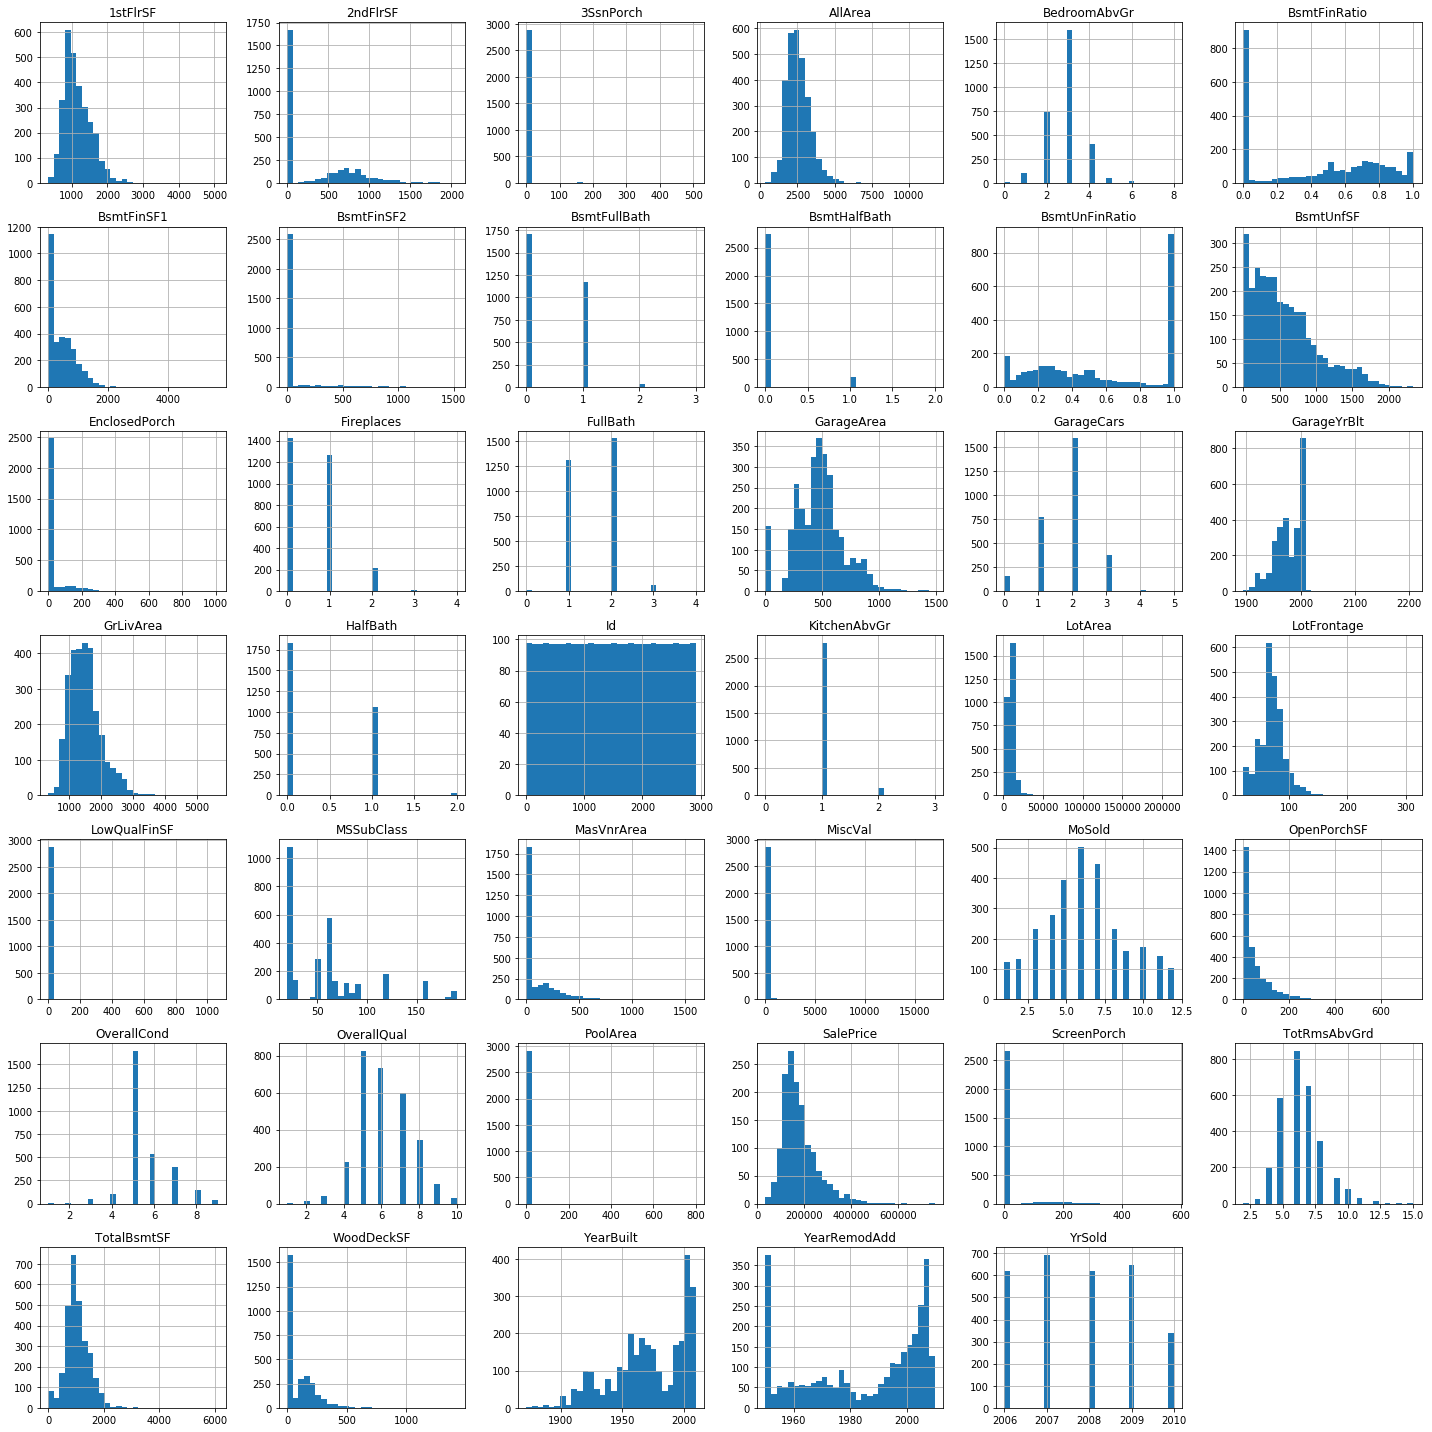

In [36]:
# ヒストグラムをかく(numeric)
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20
traintest[num_cols].hist(bins=30)
plt.tight_layout() 
plt.show()

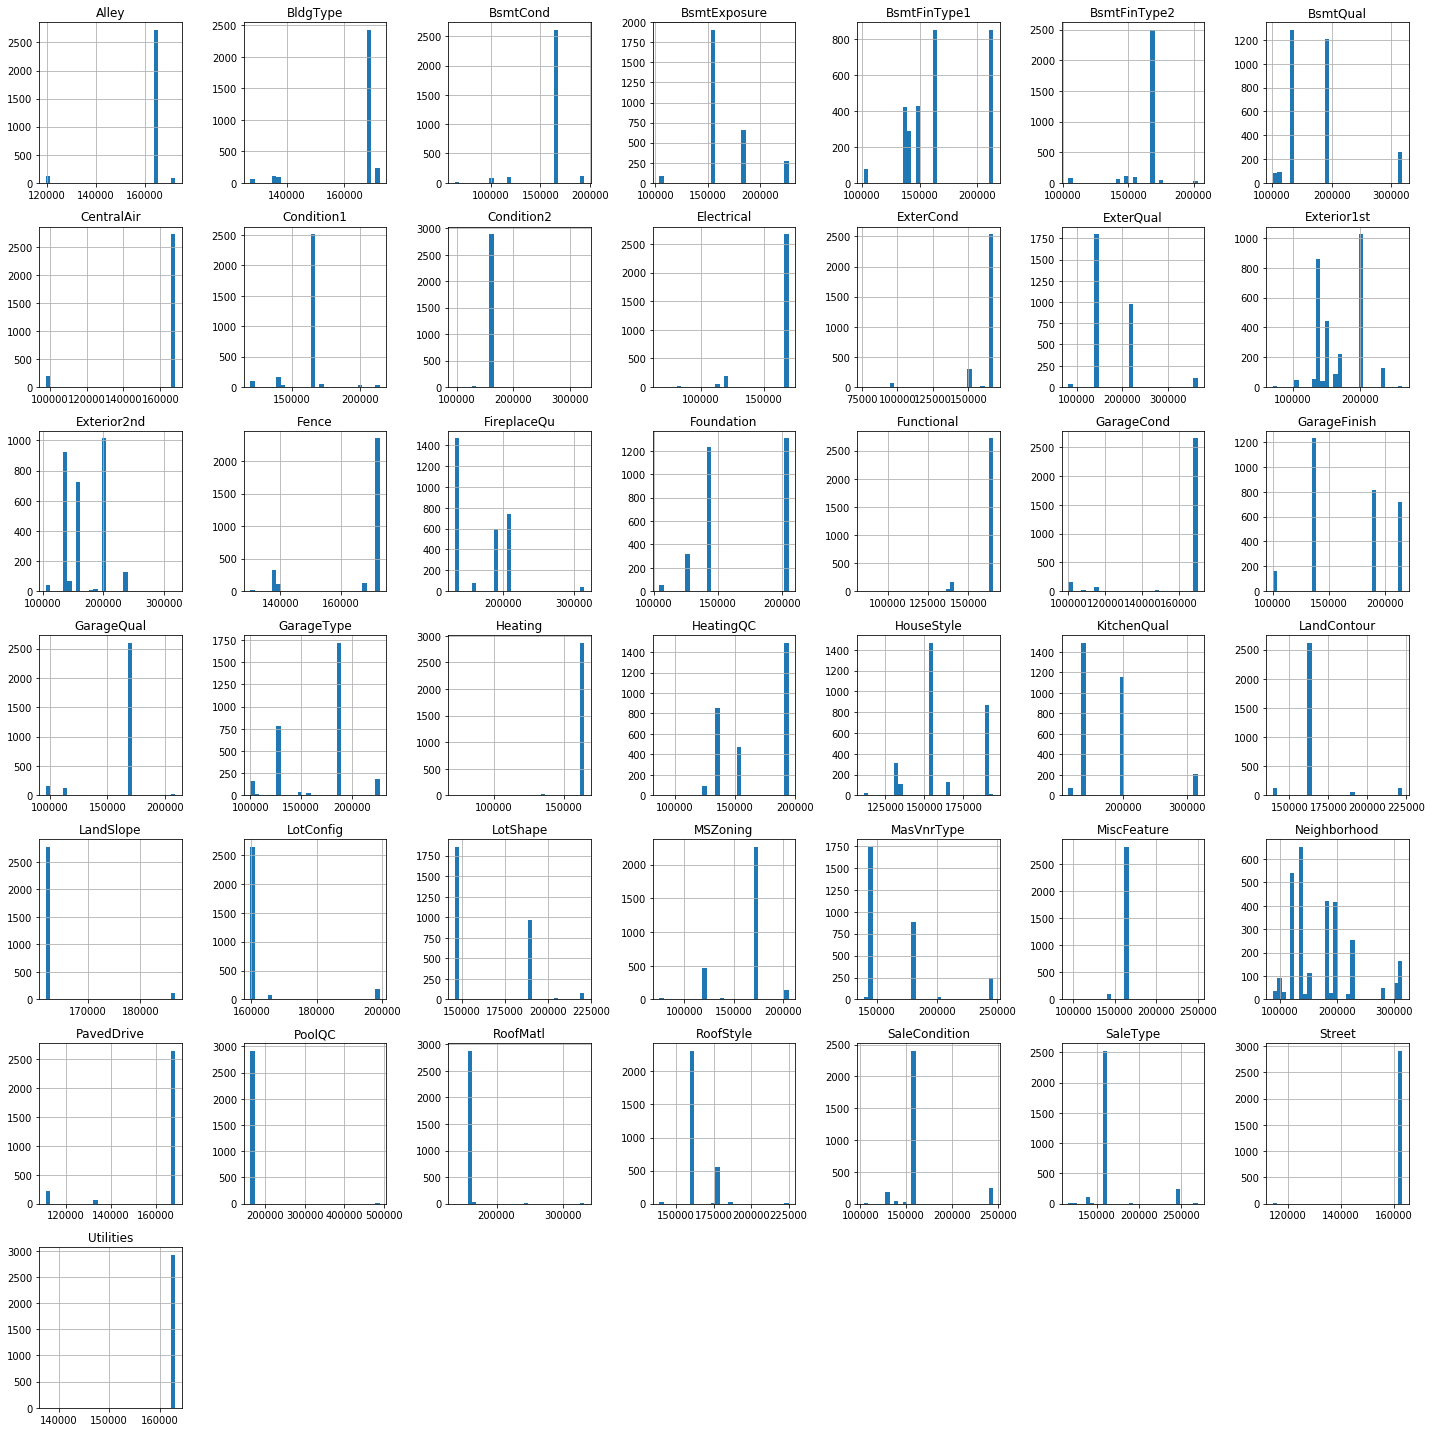

In [37]:
# ヒストグラムをかく(categorical)
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20
traintest_enc_sp[cat_cols].hist(bins=30)
plt.tight_layout() 
plt.show()

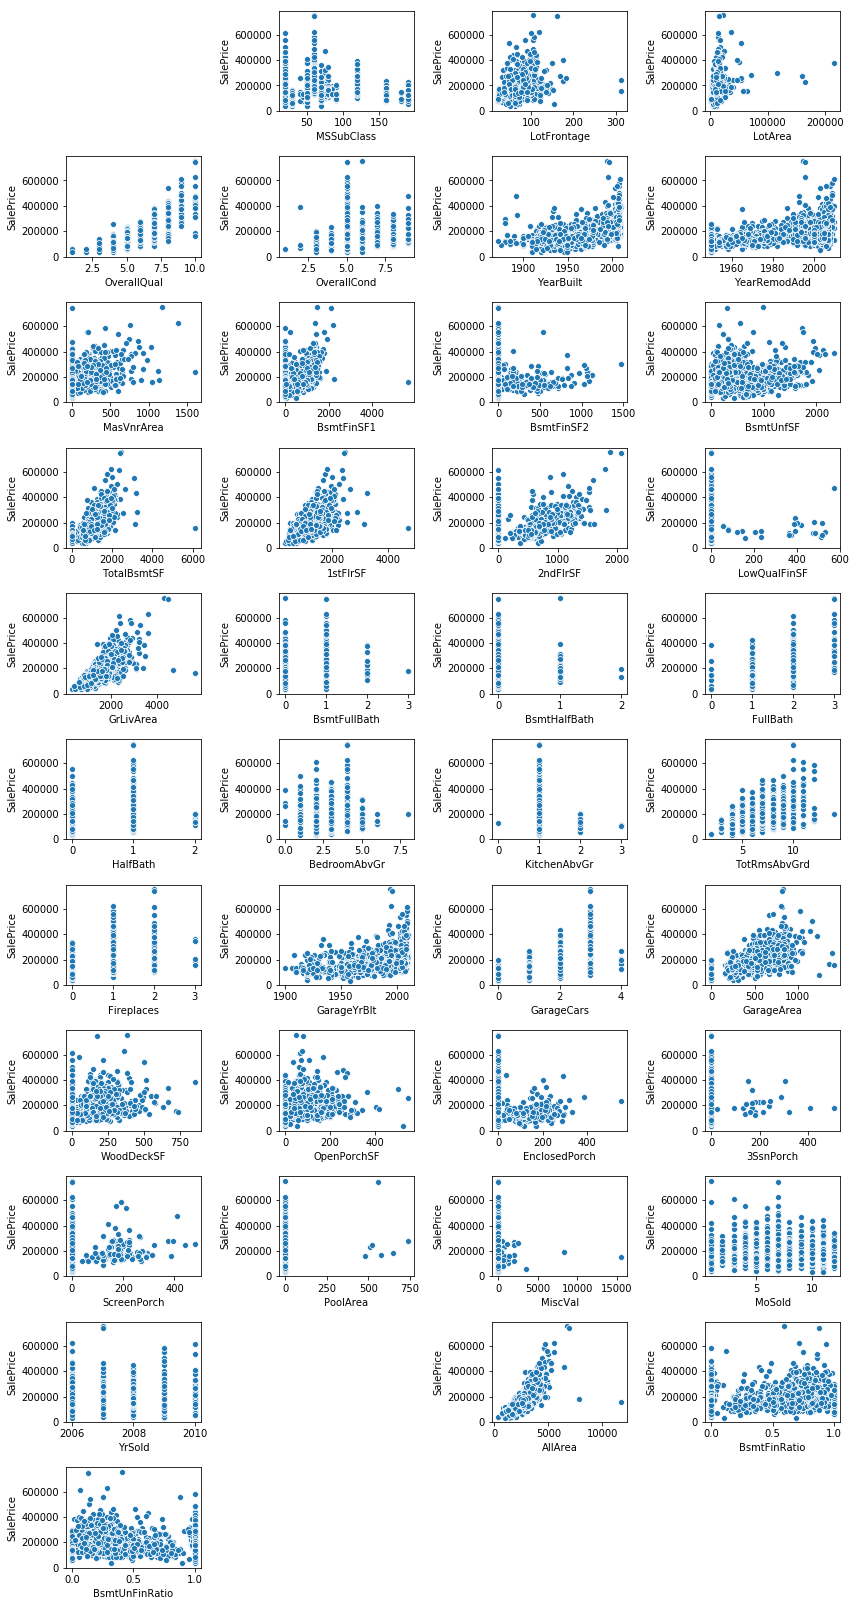

In [38]:
# SalePriceと比べてみる
f = plt.figure(figsize=(12,24))

for i, col in enumerate(traintest[num_cols]):
    if col == 'Id' or col == 'SalePrice':
        pass
    else:
        f.add_subplot(12, 4, i+1)
        sns.scatterplot(traintest[col], train_data_Y)
    
plt.tight_layout()
plt.show()

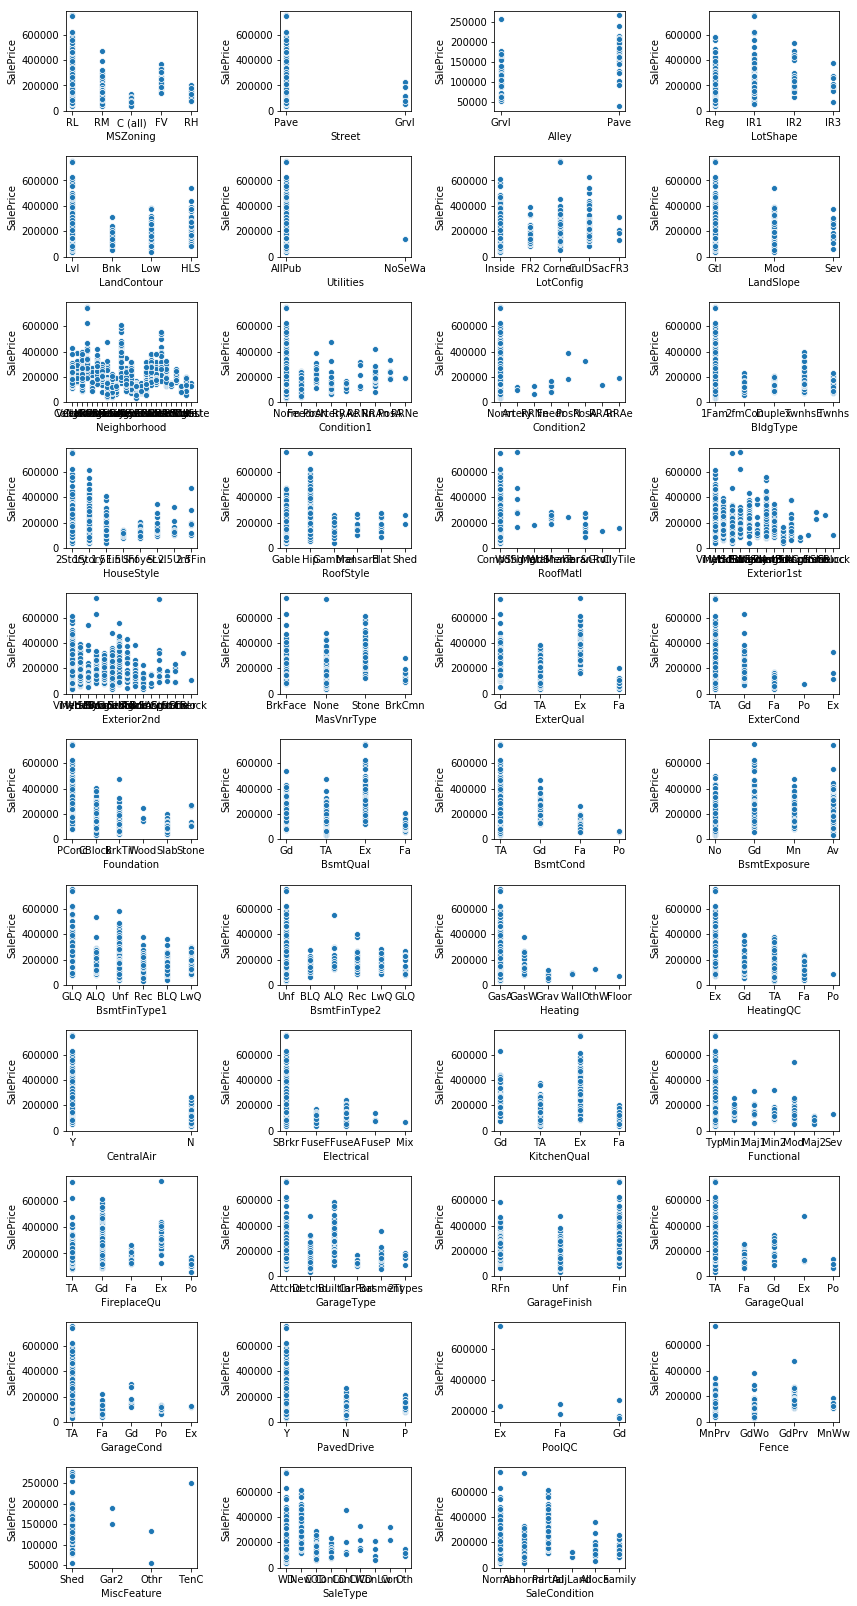

In [39]:
# SalePriceと比べてみる
f = plt.figure(figsize=(12,24))

for i, col in enumerate(traintest[cat_cols]):
    if col == 'Id' or col == 'SalePrice':
        pass
    else:
        f.add_subplot(12, 4, i+1)
        sns.scatterplot(traintest[col], train_data_Y)
    
plt.tight_layout()
plt.show()

## modeling

In [40]:
params = {'max_depth': [3,4,5], 'learning_rate': [0.03, 0.05,0.1], 'min_child_weight':[1,3,5], 'n_estimators': [500, 1000, 1500]}

In [41]:
my_model = XGBRegressor(eval_metric='mae')
cv = GridSearchCV(my_model, params, cv = 4, n_jobs =4, scoring = 'neg_mean_absolute_error', verbose=10)

In [42]:
cv.fit(train_data_X, train_data_Y,verbose=False)

Fitting 4 folds for each of 81 candidates, totalling 324 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   14.6s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   19.4s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   29.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   35.8s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   48.5s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   57.3s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed:  2.8min
[Parallel(

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mae', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'max_depth': [3, 4, 5], 'learning_rate': [0.03, 0.05, 0.1], 'min_child_weight': [1, 3, 5], 'n_estimators': [500, 1000, 1500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=10)

In [43]:
best_model = cv.best_estimator_
best_score = -cv.best_score_
cvResultsdf = pd.DataFrame(columns=['Model Name','CV Mean Score','Model'])
cvResultsdf.loc[len(cvResultsdf)] = ['XGBoost', best_score, cv]
print("CV Mean MAE for XGBoost: {:,.0f}".format(best_score))

CV Mean MAE for XGBoost: 15,508


In [44]:
best_model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mae', gamma=0, learning_rate=0.03,
       max_delta_step=0, max_depth=5, min_child_weight=3, missing=None,
       n_estimators=1000, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [45]:
predictions = best_model.predict(test_data_X)

In [46]:
with open("20190325_02_submission.csv","w") as fout:
    fout.write("Id,SalePrice\n")
    i = 0
    for predicted_price in predictions:
        fout.write(str(1461+i) + "," + str(predicted_price) + "\n")
        i = i + 1

In [47]:
fscore = best_model.feature_importances_

In [48]:
label = train_data_X.columns

In [49]:
importance_dict = dict(zip(label.values,fscore))

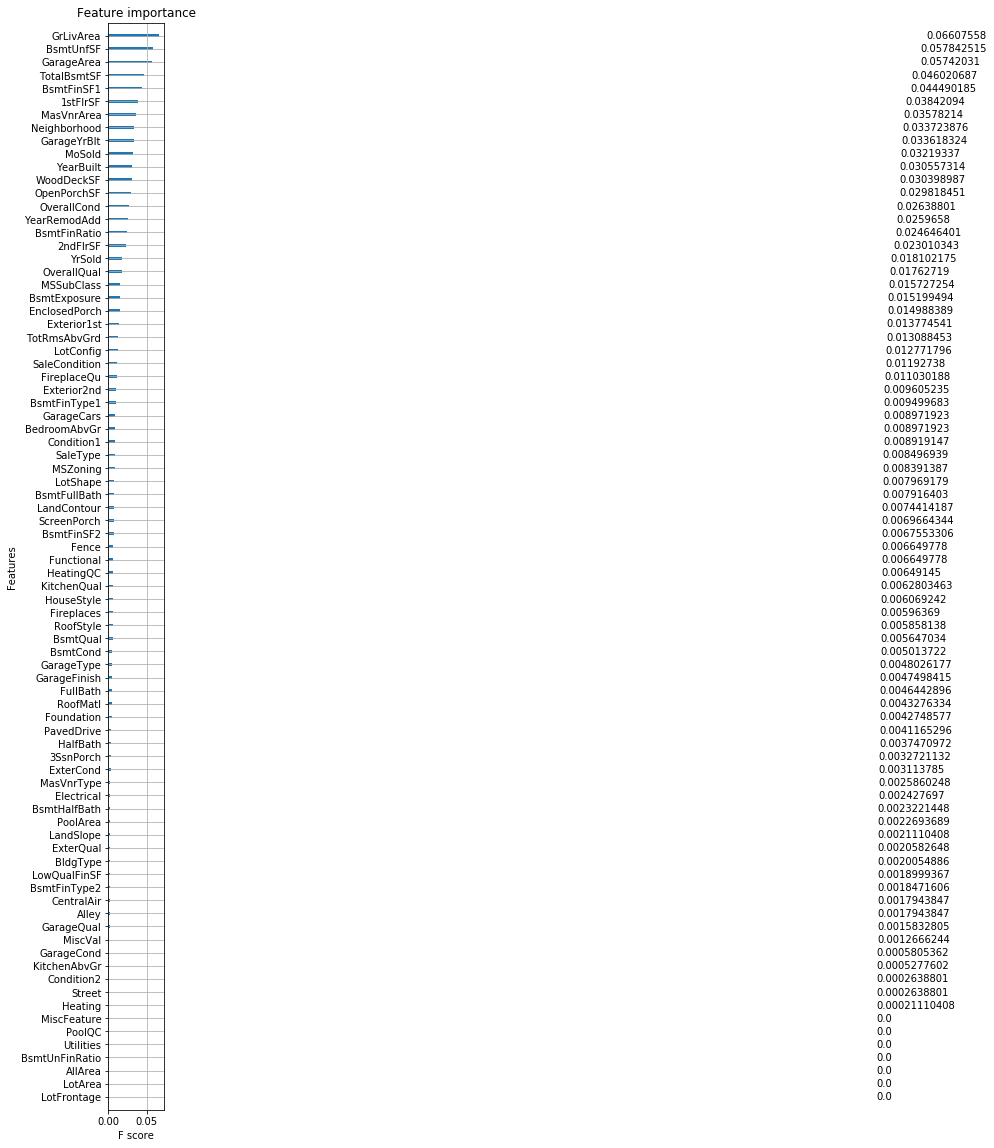

In [50]:
ax = plot_importance(importance_dict)
fig = ax.figure
fig.set_size_inches(1,20)